# Task
You're a data scientist building a binary classification model to predict credit default (default.payment.next.month: 1 = Default, 0 = No Default). Write a complete, clean, and modular Jupyter notebook in Python for Google Colab. Follow the structure below:

1. data loading and preprocessing
load train_dataset_final1.csv and validate_dataset_final.csv

2. Exploratory Data Analysis (EDA)
3. Financial Insight
4. Class Imbalance Handling
5.Feature Engineering
6. Model BuildingTrain and compare:
    Logistic Regression
    Decision Tree
    XGBoost
    LightGBM

Here is all the data you need:
"train_dataset_final1.csv"
"validate_dataset_final.csv"

## Data loading

### Subtask:
Load the training and validation datasets.


**Reasoning**:
Load the two datasets into pandas DataFrames and display the first 5 rows of each to verify.



In [ ]:
import pandas as pd

try:
    train_df = pd.read_csv('train_dataset_final1.csv')
    validate_df = pd.read_csv('validate_dataset_final.csv')
    display(train_df.head())
    display(validate_df.head())
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found.")
except pd.errors.ParserError:
    print("Error: There was an issue parsing the CSV file(s). Check the file format.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Error: There was an issue parsing the CSV file(s). Check the file format.


**Reasoning**:
The previous attempt failed due to a parsing error.  I'll try again, but this time I will explicitly specify the separator as a comma, and handle potential errors more gracefully.



In [2]:
import pandas as pd

try:
    train_df = pd.read_csv('train_dataset_final1.csv', sep=',', engine='python', on_bad_lines='skip')
    validate_df = pd.read_csv('validate_dataset_final.csv', sep=',', engine='python', on_bad_lines='skip')
    display(train_df.head())
    display(validate_df.head())
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found.")
except pd.errors.ParserError:
    print("Error: There was an issue parsing the CSV file(s).  Check the file format and separators.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017.0,2,0,2,60000,25.0,2.0,2.0,2.0,0.0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0.0
1,5018.0,2,1,1,290000,24.0,0.0,0.0,-2.0,-2.0,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0.0
2,5019.0,1,0,2,180000,63.0,0.0,0.0,0.0,0.0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0.0
3,5020.0,1,1,2,210000,43.0,0.0,0.0,0.0,0.0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0.0
4,5021.0,2,0,1,280000,32.0,-2.0,-2.0,-2.0,-2.0,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0.0


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


## Data exploration

### Subtask:
Explore the training dataset: `train_df`.


**Reasoning**:
Explore the training dataset `train_df` by examining its shape, data types, descriptive statistics, missing values, and distributions of key features. Visualize the class imbalance in the target variable.



Shape of the DataFrame: (35531, 27)

Data Types:
 Customer_ID           float64
marriage                int64
sex                     int64
education               int64
LIMIT_BAL               int64
age                   float64
pay_0                 float64
pay_2                 float64
pay_3                 float64
pay_4                 float64
pay_5                 float64
pay_6                 float64
Bill_amt1             float64
Bill_amt2             float64
Bill_amt3             float64
Bill_amt4             float64
Bill_amt5             float64
Bill_amt6             float64
pay_amt1              float64
pay_amt2              float64
pay_amt3              float64
pay_amt4              float64
pay_amt5              float64
pay_amt6              float64
AVG_Bill_amt          float64
PAY_TO_BILL_ratio     float64
next_month_default    float64
dtype: object

Descriptive Statistics:
         Customer_ID      marriage           sex     education       LIMIT_BAL  \
count  35530.000000

KeyError: 'AGE'

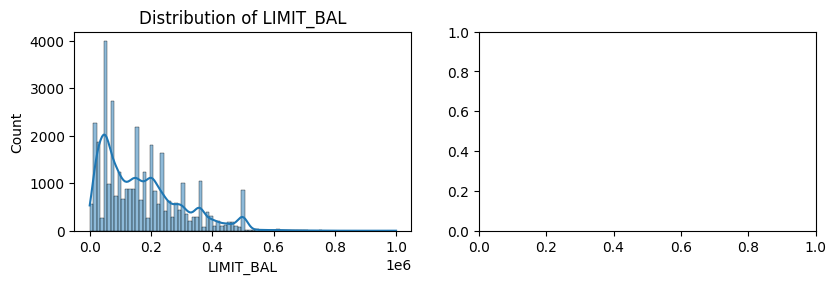

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Exploration
print("Shape of the DataFrame:", train_df.shape)
print("\nData Types:\n", train_df.dtypes)
print("\nDescriptive Statistics:\n", train_df.describe())
print("\nMissing Values:\n", train_df.isnull().sum())

# Distribution Analysis for Numerical Features
numerical_features = ['LIMIT_BAL', 'AGE', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features):
  plt.subplot(5, 4, i + 1)
  sns.histplot(train_df[col], kde=True)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Distribution Analysis for Categorical Features
categorical_features = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, data=train_df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Class Imbalance Calculation
class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print("\nClass Imbalance:")
print(class_counts)
print(class_percentages)


# Correlation Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


# Pairplots
sns.pairplot(train_df[numerical_features[:5] + ['next_month_default']], hue='next_month_default')
plt.show()

**Reasoning**:
The previous code block failed due to a KeyError for 'AGE'.  The column name 'AGE' is incorrect; it should be 'age'.  The code will be corrected to use the correct column name and re-executed.



Shape of the DataFrame: (35531, 27)

Data Types:
 Customer_ID           float64
marriage                int64
sex                     int64
education               int64
LIMIT_BAL               int64
age                   float64
pay_0                 float64
pay_2                 float64
pay_3                 float64
pay_4                 float64
pay_5                 float64
pay_6                 float64
Bill_amt1             float64
Bill_amt2             float64
Bill_amt3             float64
Bill_amt4             float64
Bill_amt5             float64
Bill_amt6             float64
pay_amt1              float64
pay_amt2              float64
pay_amt3              float64
pay_amt4              float64
pay_amt5              float64
pay_amt6              float64
AVG_Bill_amt          float64
PAY_TO_BILL_ratio     float64
next_month_default    float64
dtype: object

Descriptive Statistics:
         Customer_ID      marriage           sex     education       LIMIT_BAL  \
count  35530.000000

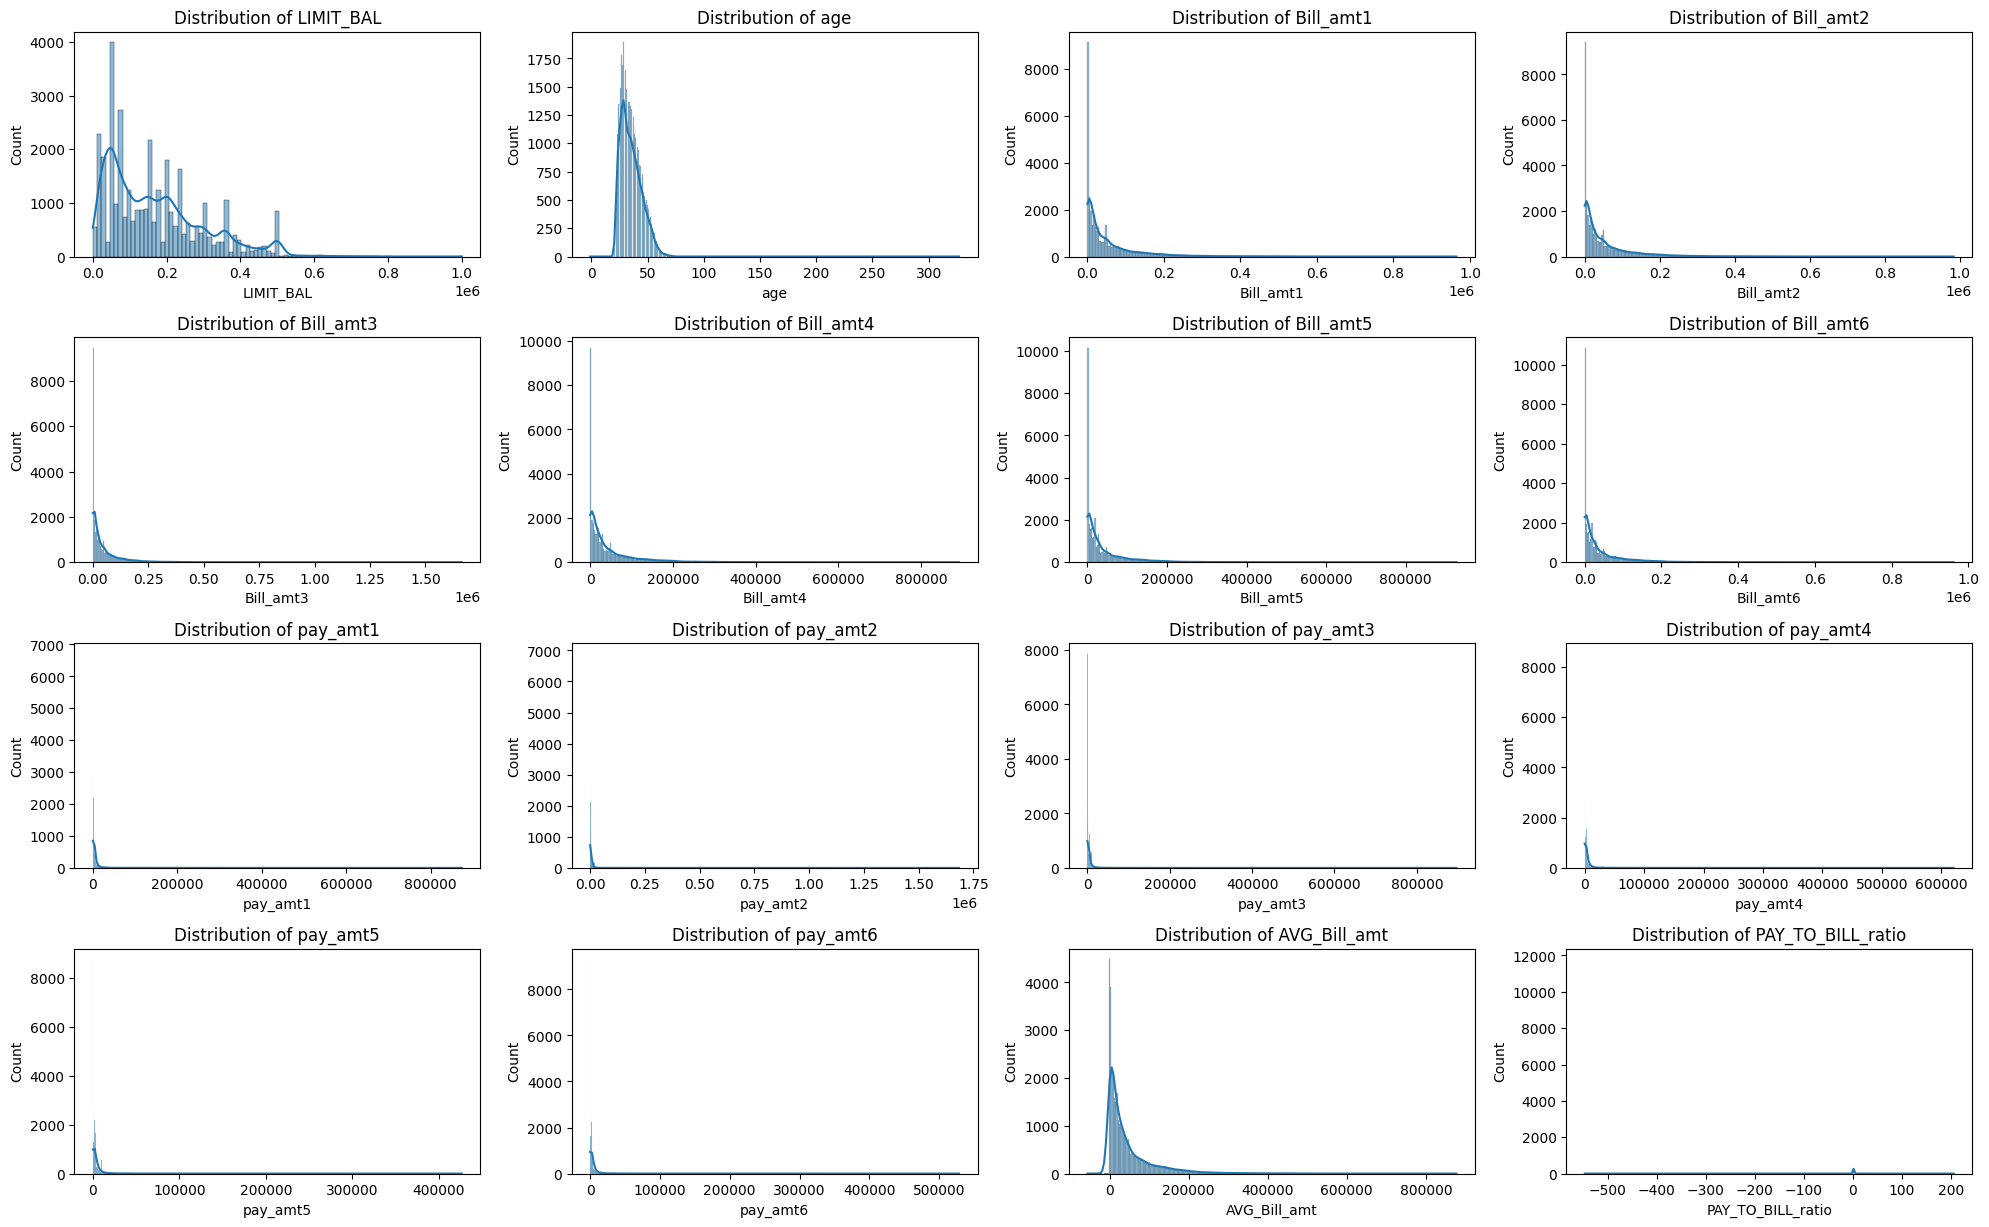

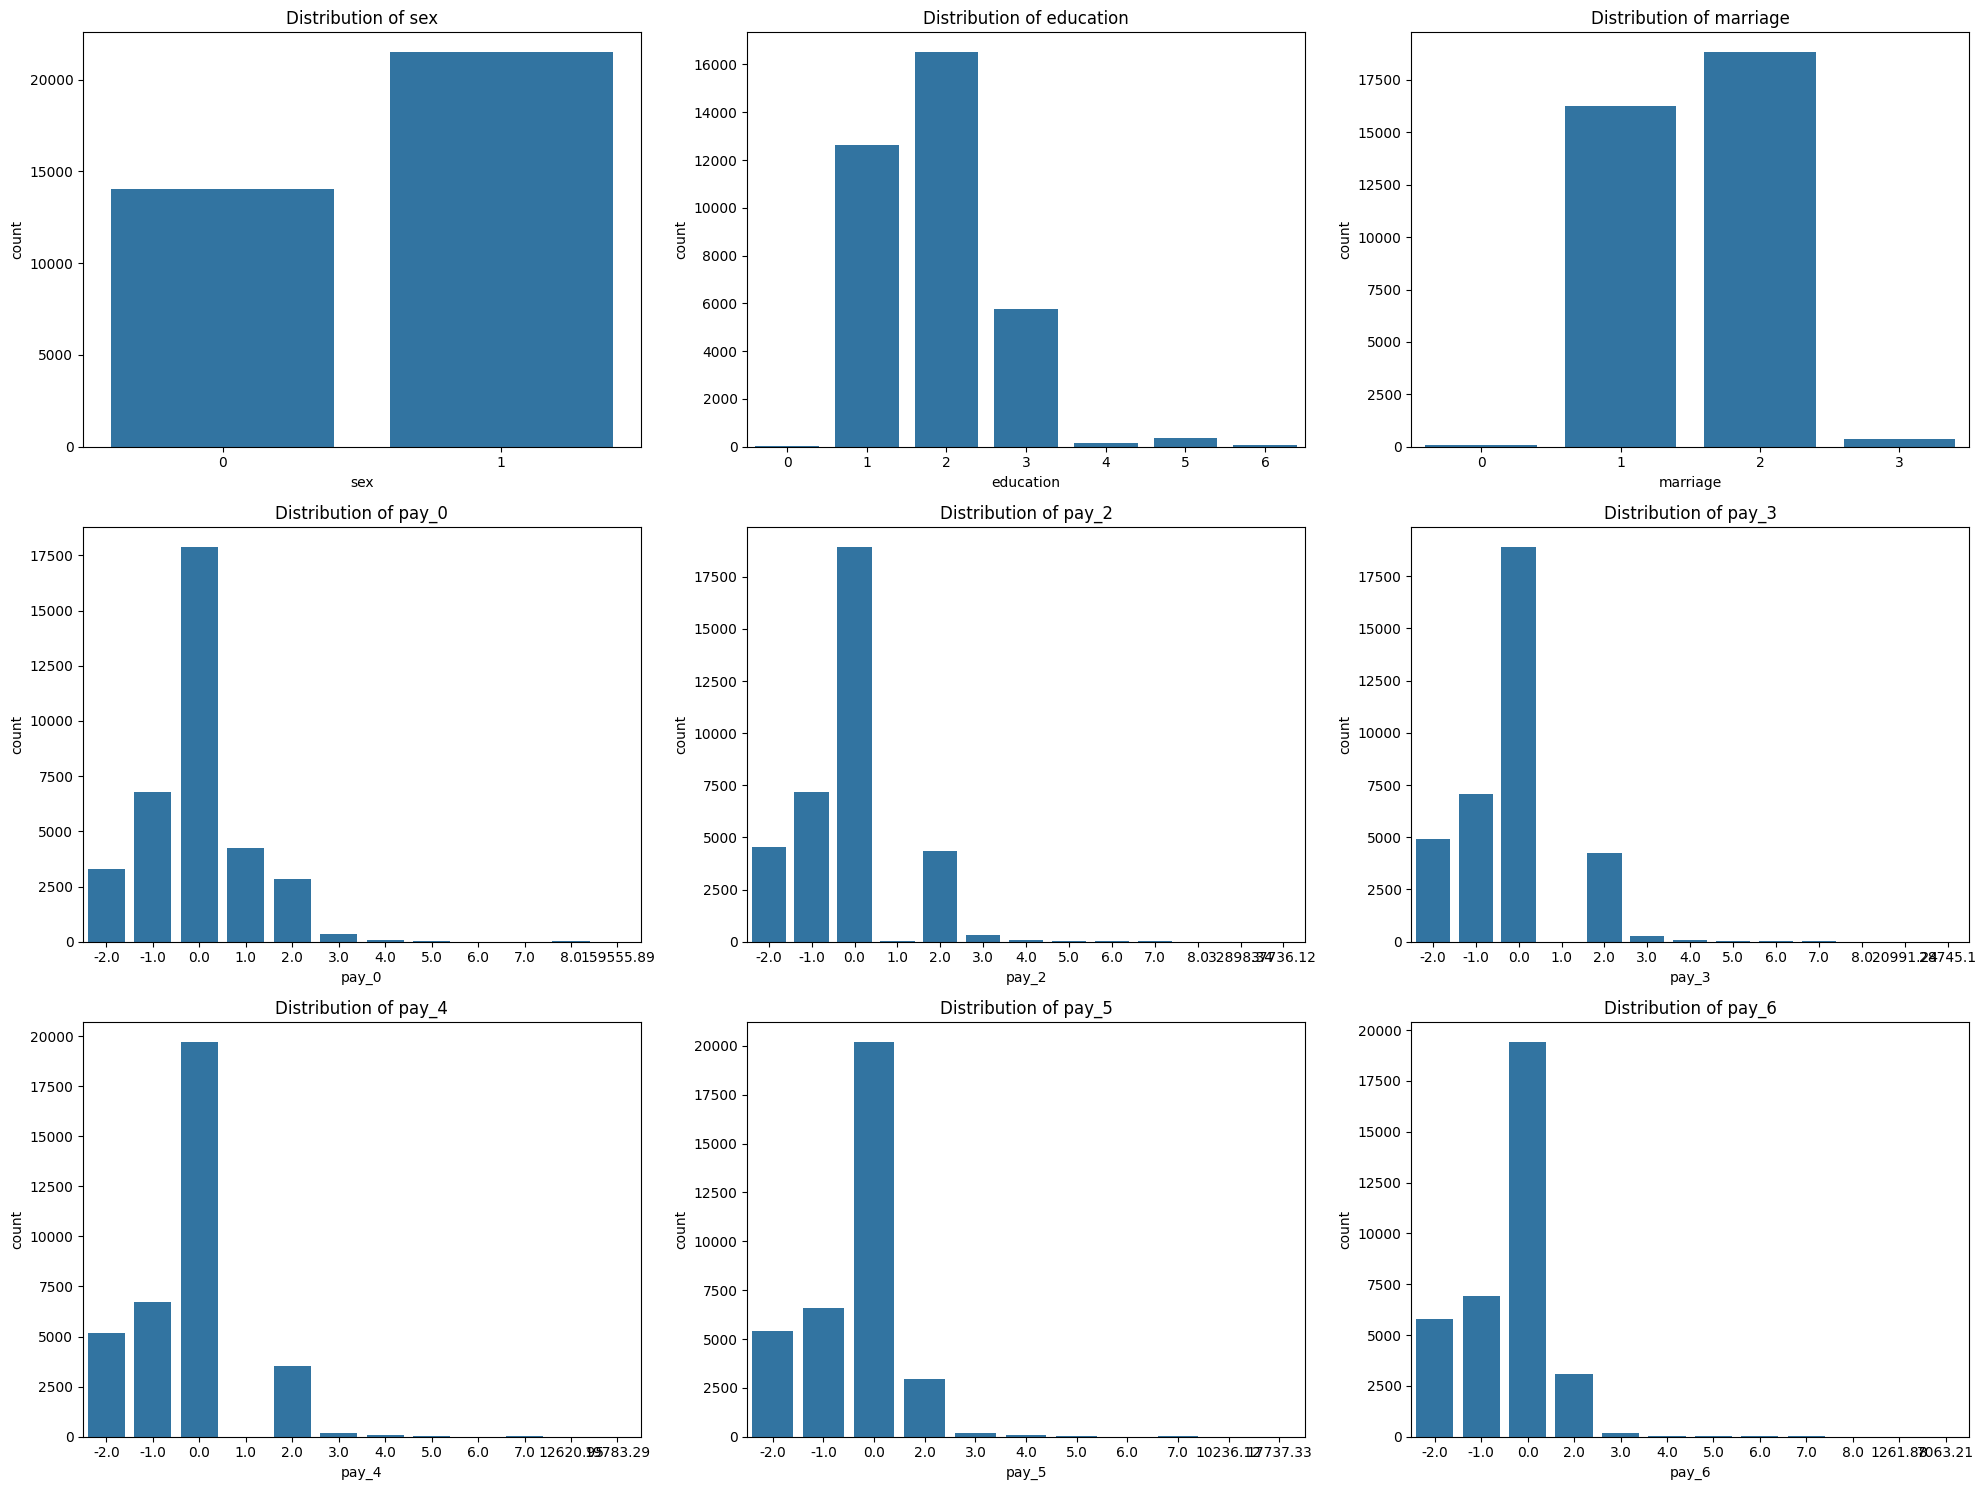

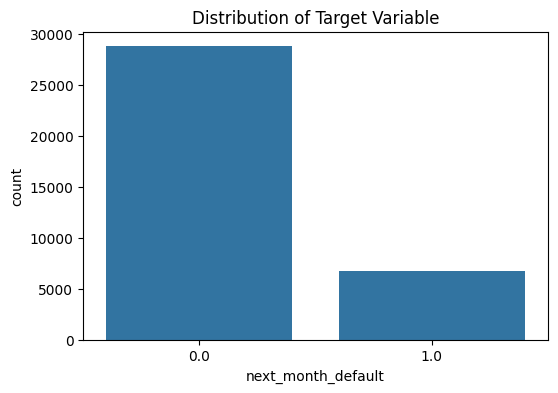


Class Imbalance:
next_month_default
0.0    28764
1.0     6764
Name: count, dtype: int64
next_month_default
0.0    80.954659
1.0    19.036897
Name: count, dtype: float64


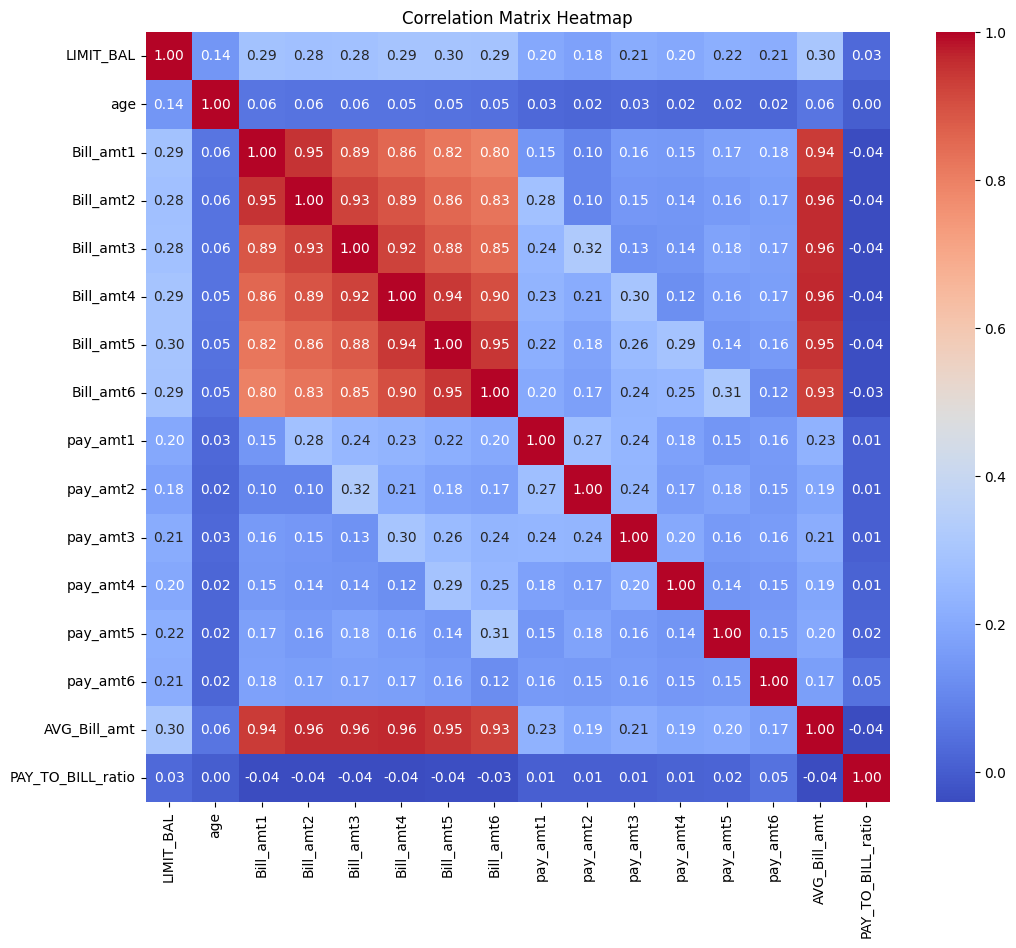

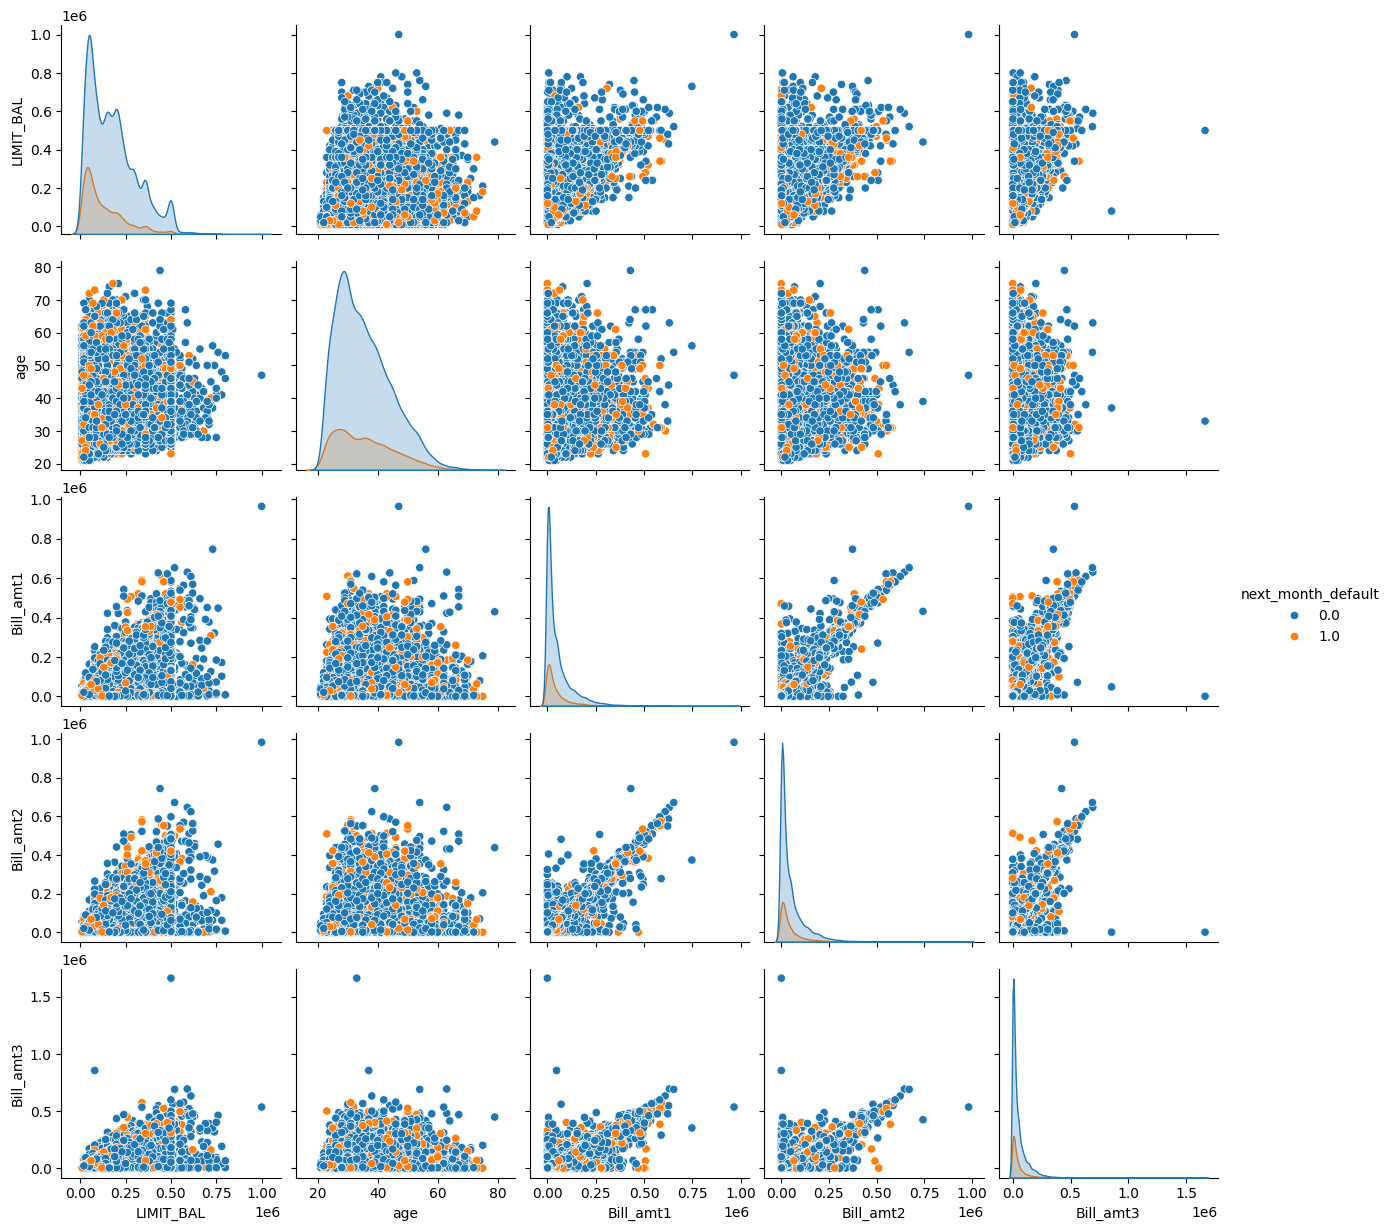

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic Exploration
print("Shape of the DataFrame:", train_df.shape)
print("\nData Types:\n", train_df.dtypes)
print("\nDescriptive Statistics:\n", train_df.describe())
print("\nMissing Values:\n", train_df.isnull().sum())

# Distribution Analysis for Numerical Features
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features):
  plt.subplot(5, 4, i + 1)
  sns.histplot(train_df[col], kde=True)
  plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Distribution Analysis for Categorical Features
categorical_features = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(20, 15))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, data=train_df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


# Distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Class Imbalance Calculation
class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print("\nClass Imbalance:")
print(class_counts)
print(class_percentages)


# Correlation Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[numerical_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


# Pairplots
sns.pairplot(train_df[numerical_features[:5] + ['next_month_default']], hue='next_month_default')
plt.show()

## Data cleaning

### Subtask:
Clean the training and validation datasets.


**Reasoning**:
Handle missing values, outliers, and encode categorical features in both train_df and validate_df.



In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Handle missing values
for df in [train_df, validate_df]:
    # Impute missing 'age' with the median
    df['age'].fillna(df['age'].median(), inplace=True)

    # Investigate and remove rows with missing 'Customer_ID'
    df.dropna(subset=['Customer_ID'], inplace=True)

# Outlier Treatment (Winsorization)
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
for df in [train_df, validate_df]:
    for col in numerical_features:
        df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))

# Data Encoding (Label Encoding for categorical features)
categorical_cols = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for df in [train_df, validate_df]:
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Data Consistency Checks
for df in [train_df, validate_df]:
    # Check 'PAY_0' to 'PAY_6' for consistency
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    for col in pay_cols:
        df[col] = np.clip(df[col], -2, 8)

    # Check 'LIMIT_BAL'
    df['LIMIT_BAL'] = np.clip(df['LIMIT_BAL'], 10000, 1000000)

    # Check 'age'
    df['age'] = np.clip(df['age'], 20, 80)

display(train_df.head())
display(validate_df.head())

<ipython-input-5-fd541078a359>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].median(), inplace=True)
<ipython-input-5-fd541078a359>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017.0,2,0,2,60000,25.0,4,4,4,2,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0.0
1,5018.0,2,1,1,290000,24.0,2,2,0,0,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0.0
2,5019.0,1,0,2,180000,60.0,2,2,2,2,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0.0
3,5020.0,1,1,2,210000,43.0,2,2,2,2,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0.0
4,5021.0,2,0,1,280000,32.0,0,0,0,0,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0.0


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,2,2,2,2,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,1,1,1,2,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,2,2,2,2,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,2,2,2,4,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,2,2,2,2,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


**Reasoning**:
The previous code block had chained assignment warnings.  I will rewrite the code to fix these warnings and ensure all operations are performed inplace correctly.



In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Handle missing values
for df in [train_df, validate_df]:
    # Impute missing 'age' with the median
    df['age'] = df['age'].fillna(df['age'].median())

    # Investigate and remove rows with missing 'Customer_ID'
    df.dropna(subset=['Customer_ID'], inplace=True)

# Outlier Treatment (Winsorization)
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
for df in [train_df, validate_df]:
    for col in numerical_features:
        df[col] = np.clip(df[col], df[col].quantile(0.01), df[col].quantile(0.99))

# Data Encoding (Label Encoding for categorical features)
categorical_cols = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
for df in [train_df, validate_df]:
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# Data Consistency Checks
for df in [train_df, validate_df]:
    # Check 'PAY_0' to 'PAY_6' for consistency
    pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
    for col in pay_cols:
        df[col] = np.clip(df[col], -2, 8)

    # Check 'LIMIT_BAL'
    df['LIMIT_BAL'] = np.clip(df['LIMIT_BAL'], 10000, 1000000)

    # Check 'age'
    df['age'] = np.clip(df['age'], 20, 80)

display(train_df.head())
display(validate_df.head())

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017.0,2,0,2,60000,25.0,4,4,4,2,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0.0
1,5018.0,2,1,1,290000,24.0,2,2,0,0,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0.0
2,5019.0,1,0,2,180000,60.0,2,2,2,2,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0.0
3,5020.0,1,1,2,210000,43.0,2,2,2,2,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0.0
4,5021.0,2,0,1,280000,32.0,0,0,0,0,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0.0


,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,2,2,2,2,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,1,1,1,2,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,2,2,2,2,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,2,2,2,4,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,2,2,2,2,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


## Data analysis

### Subtask:
Conduct detailed exploratory data analysis (EDA) on the training dataset (`train_df`), focusing on the distribution of the target variable ("default.payment.next.month") and the relationship between features and the target. Visualize key findings.  Also, perform the financial analysis as detailed below.


**Reasoning**:
Visualize the distribution of the target variable and the relationship between features and the target variable, then perform the financial analysis as instructed.



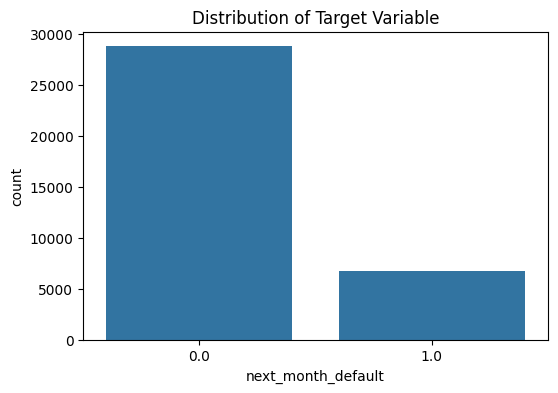


Class Imbalance:
next_month_default
0.0    28764
1.0     6764
Name: count, dtype: int64
next_month_default
0.0    80.956938
1.0    19.037433
Name: count, dtype: float64


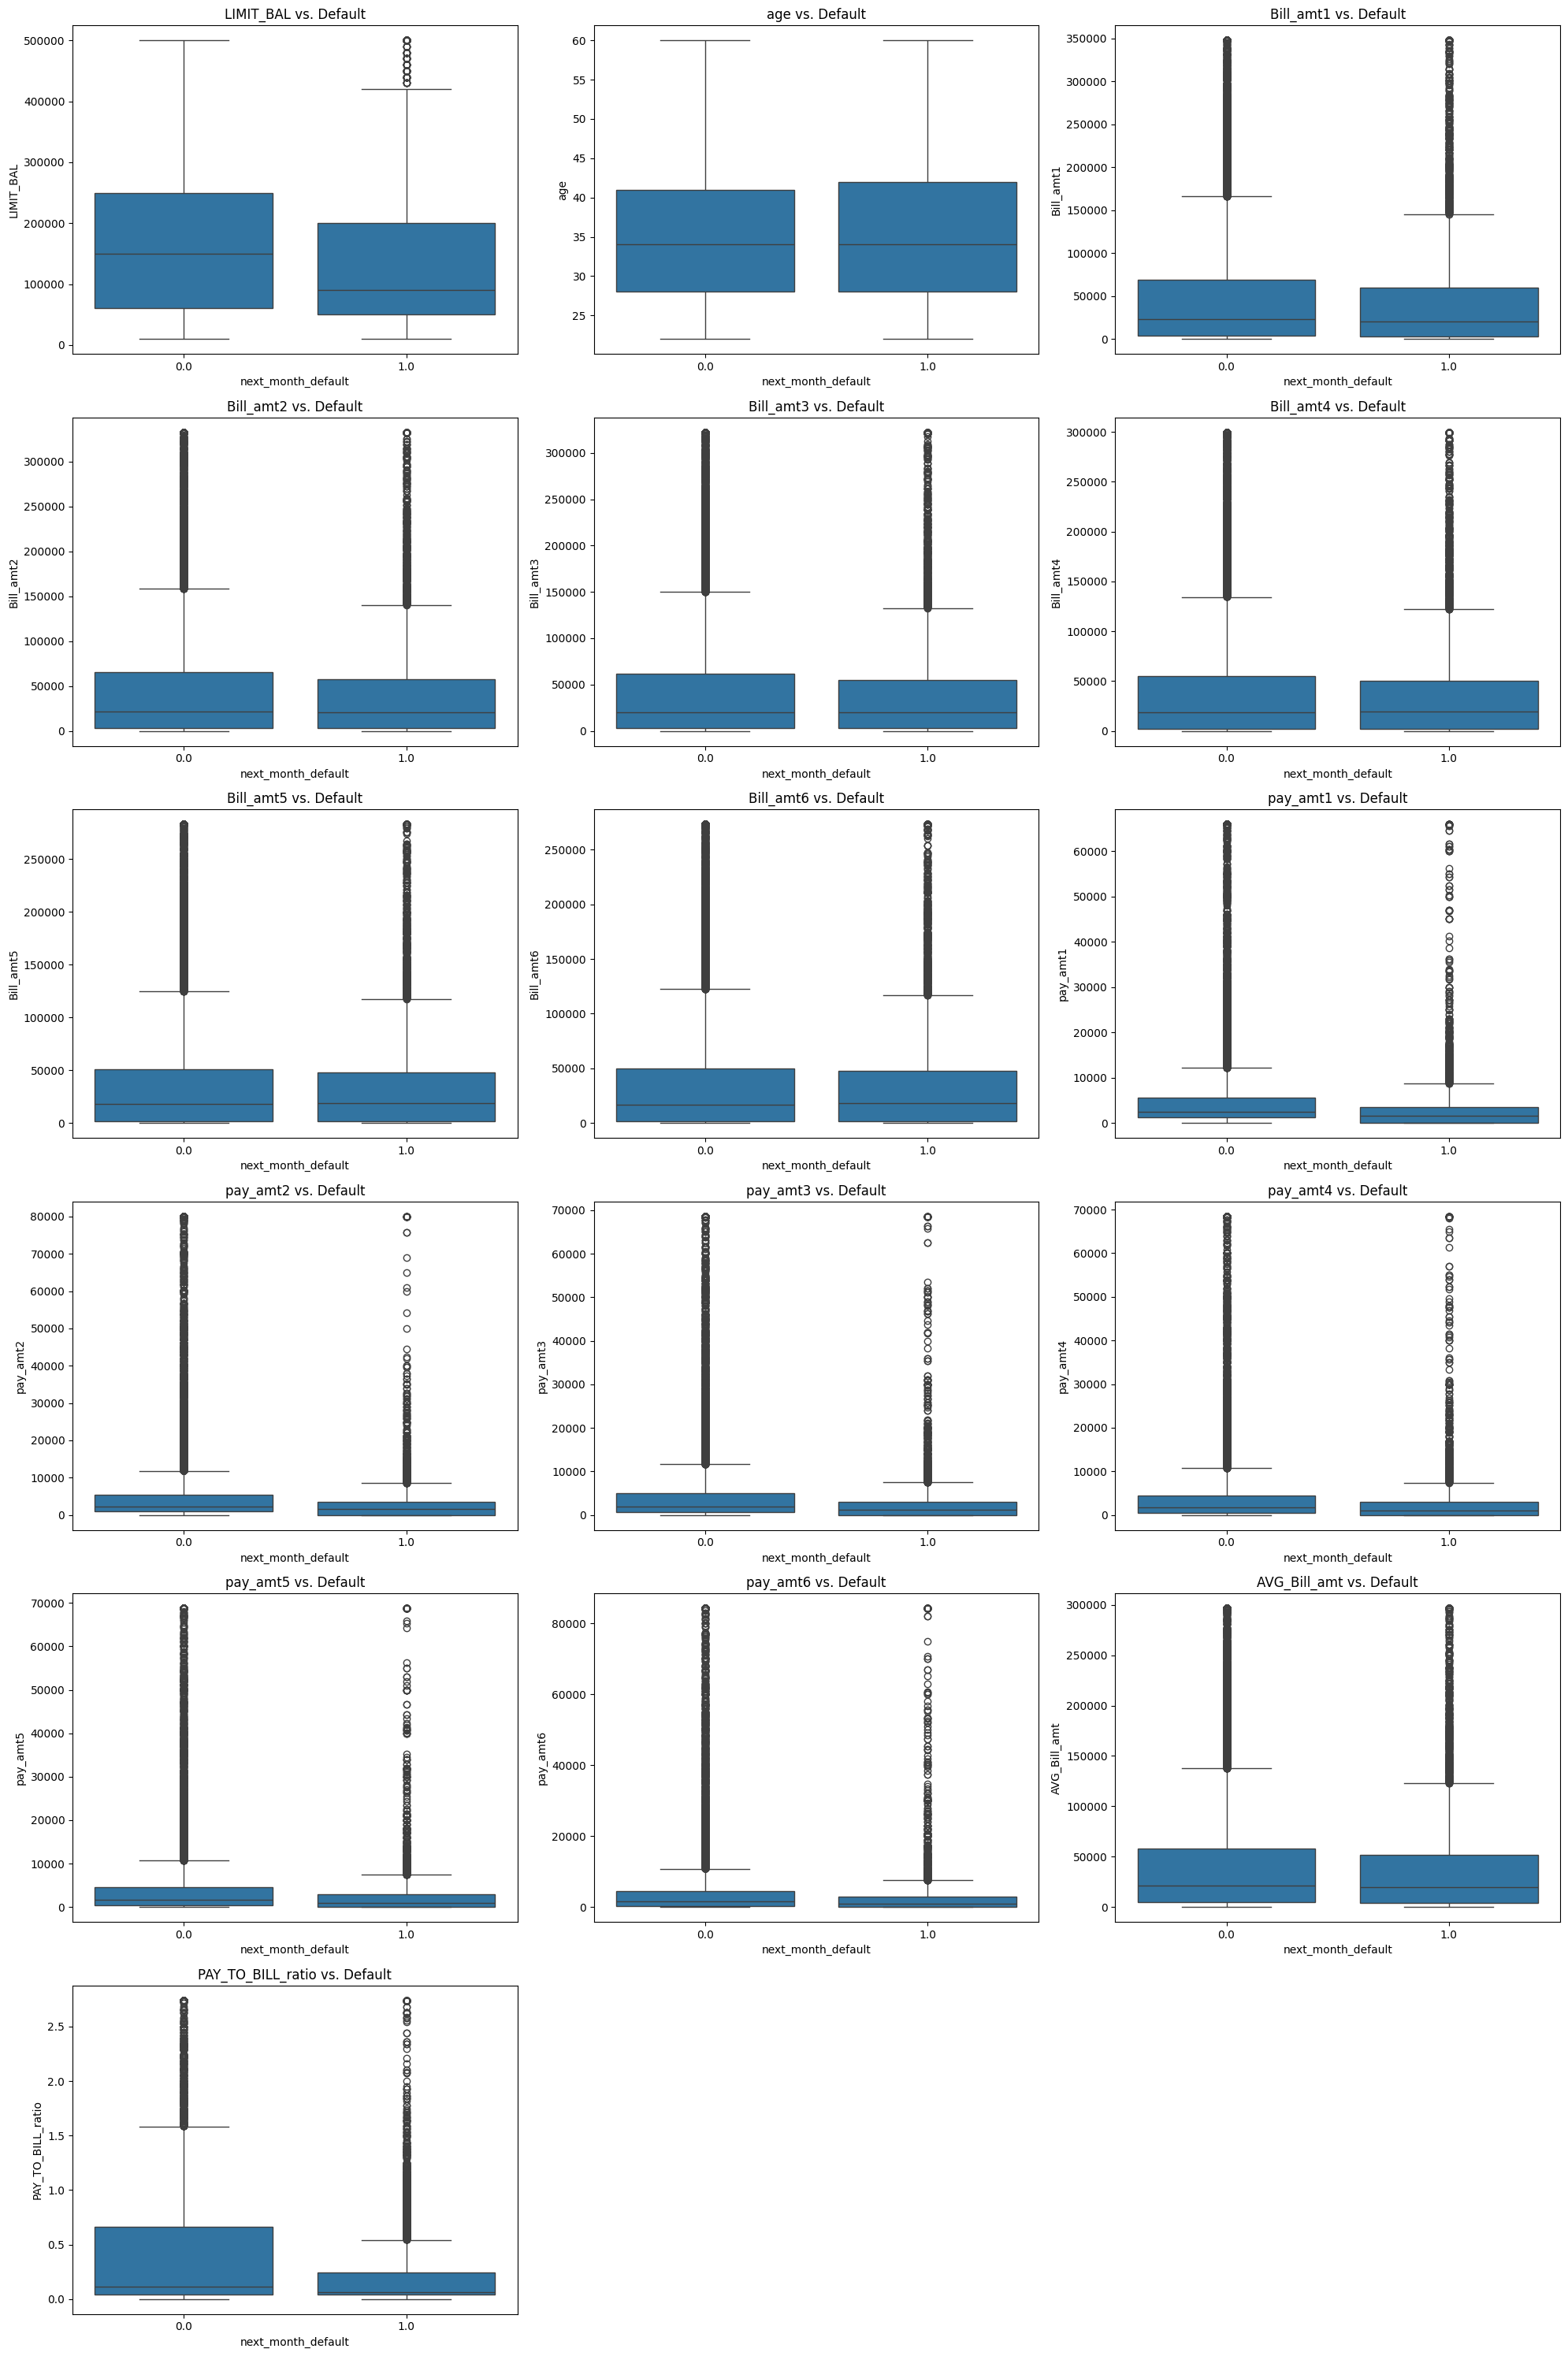

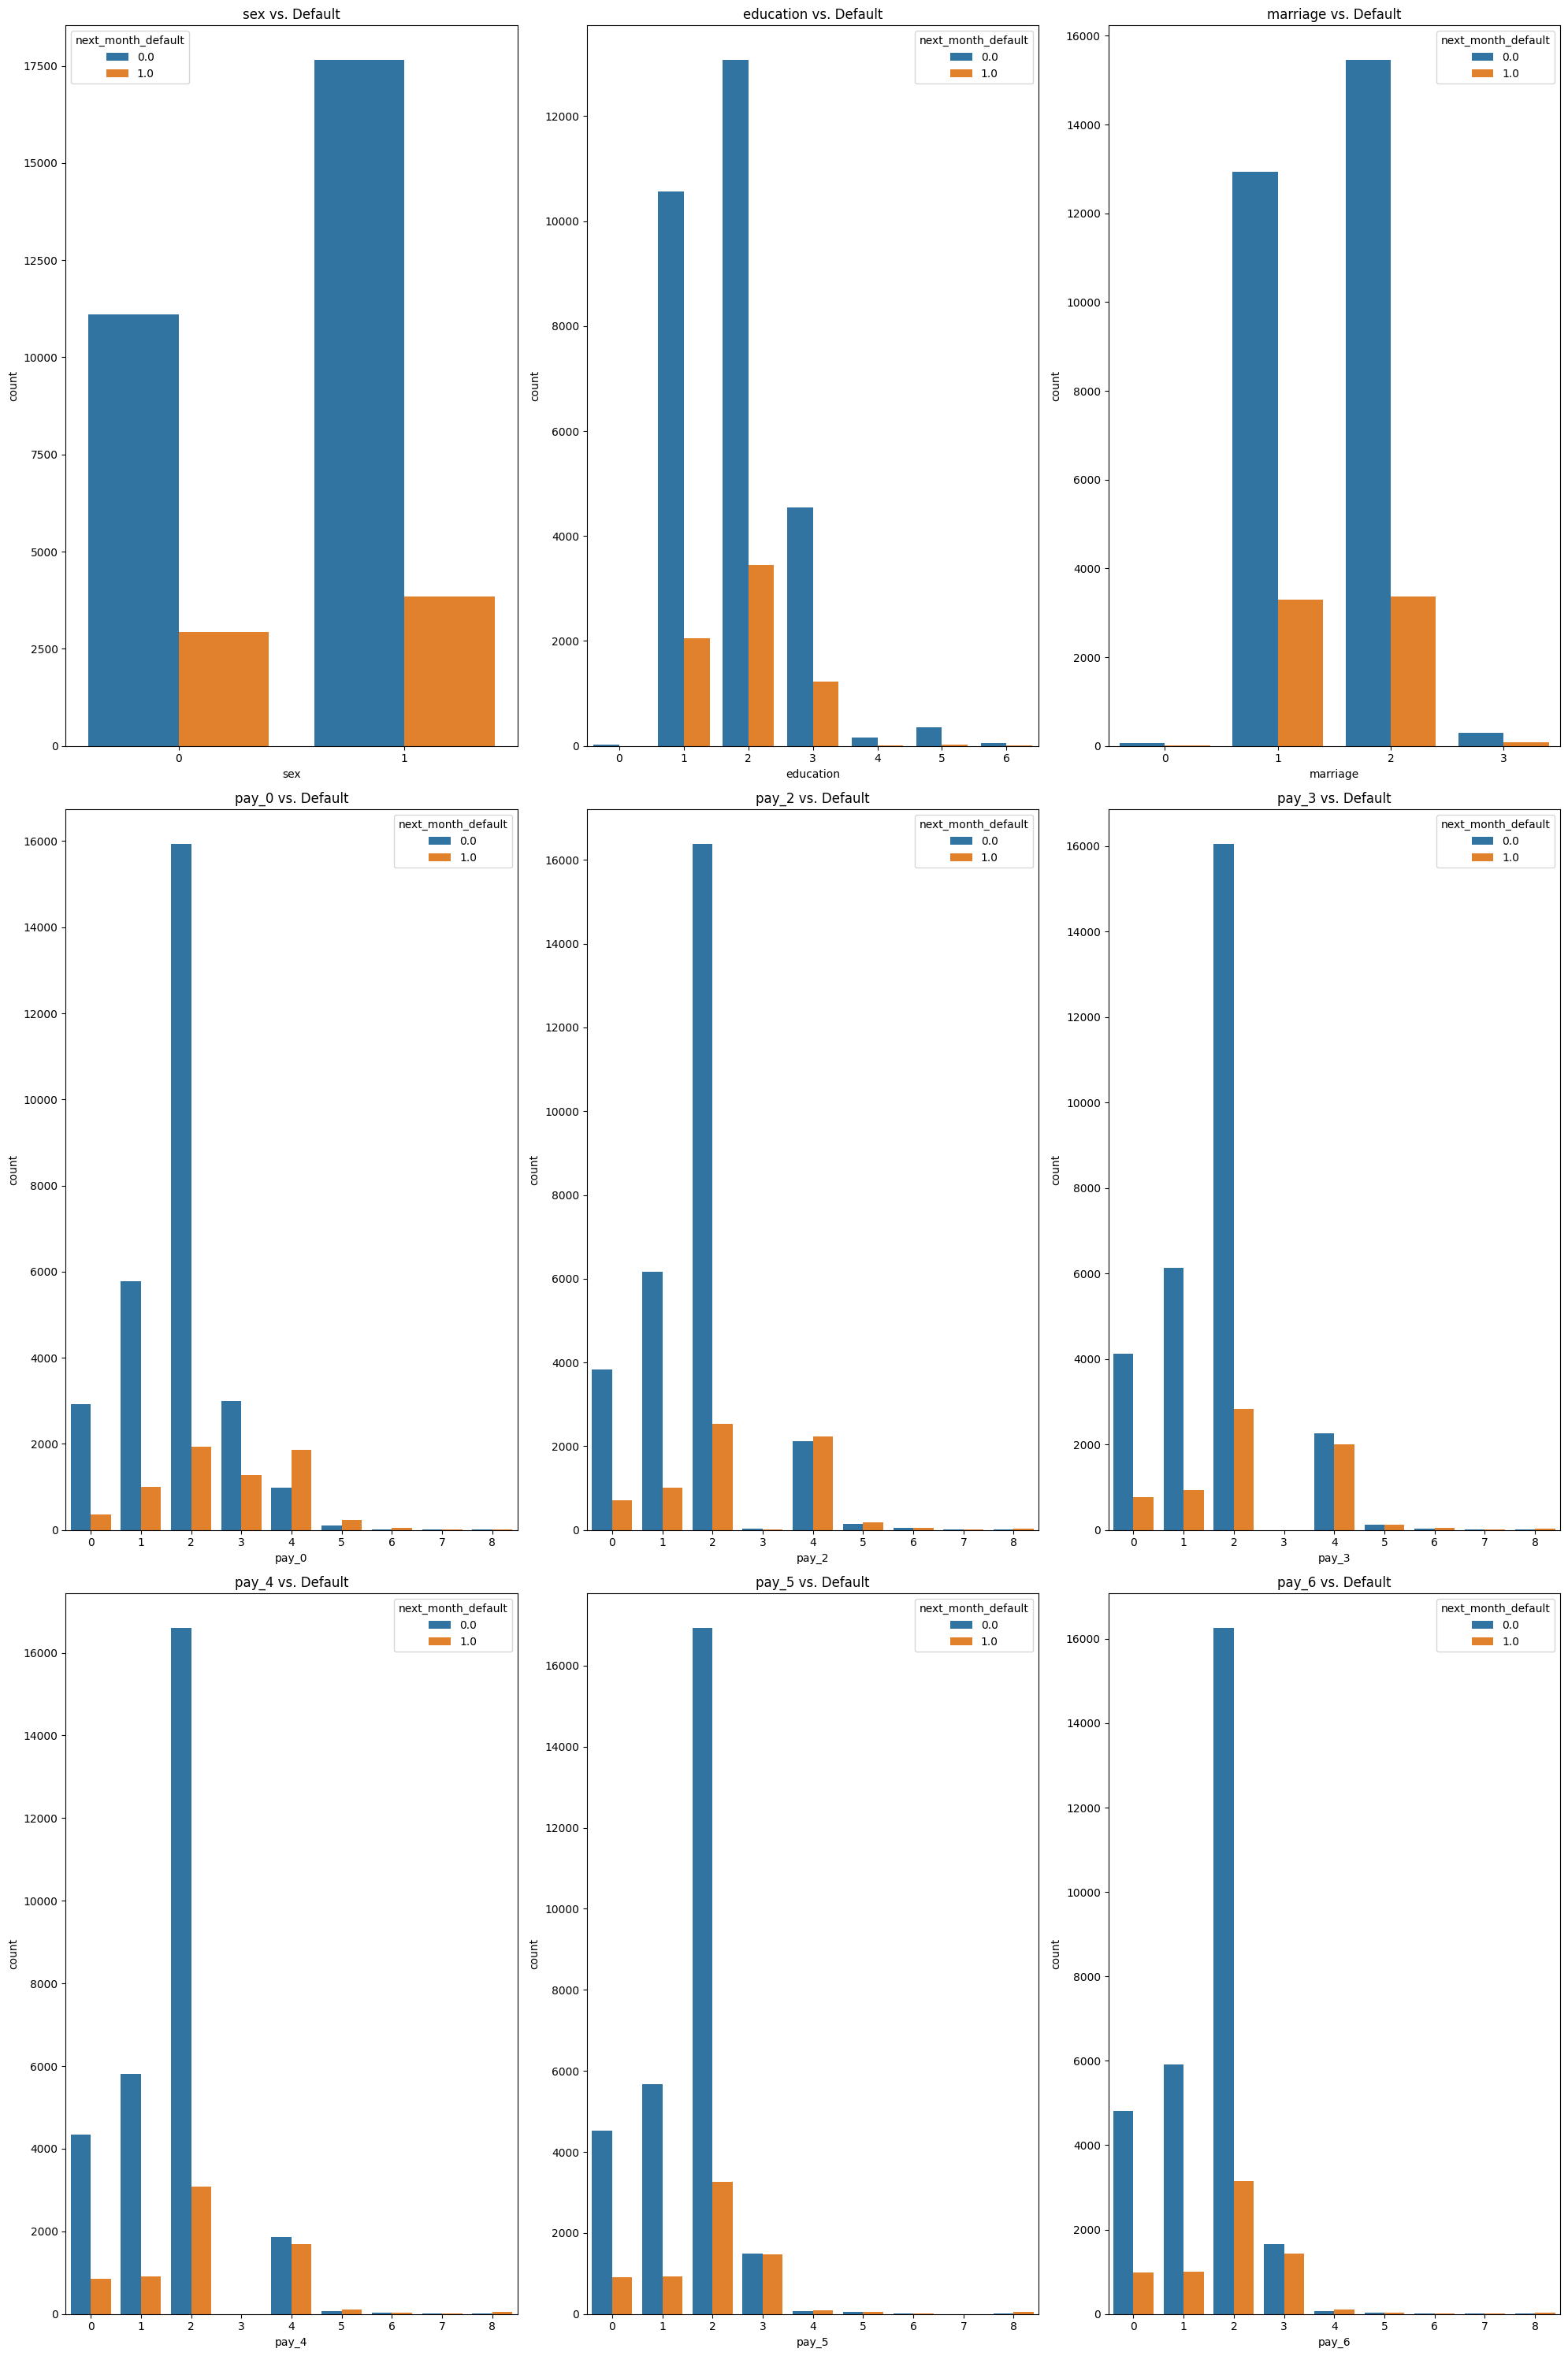

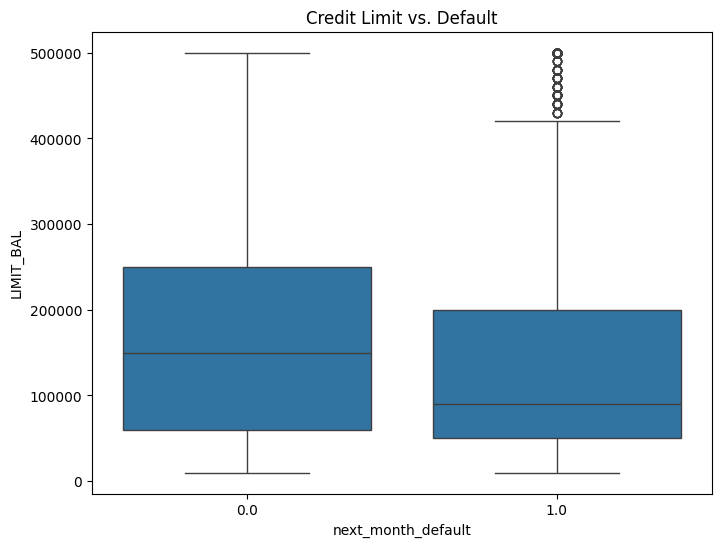

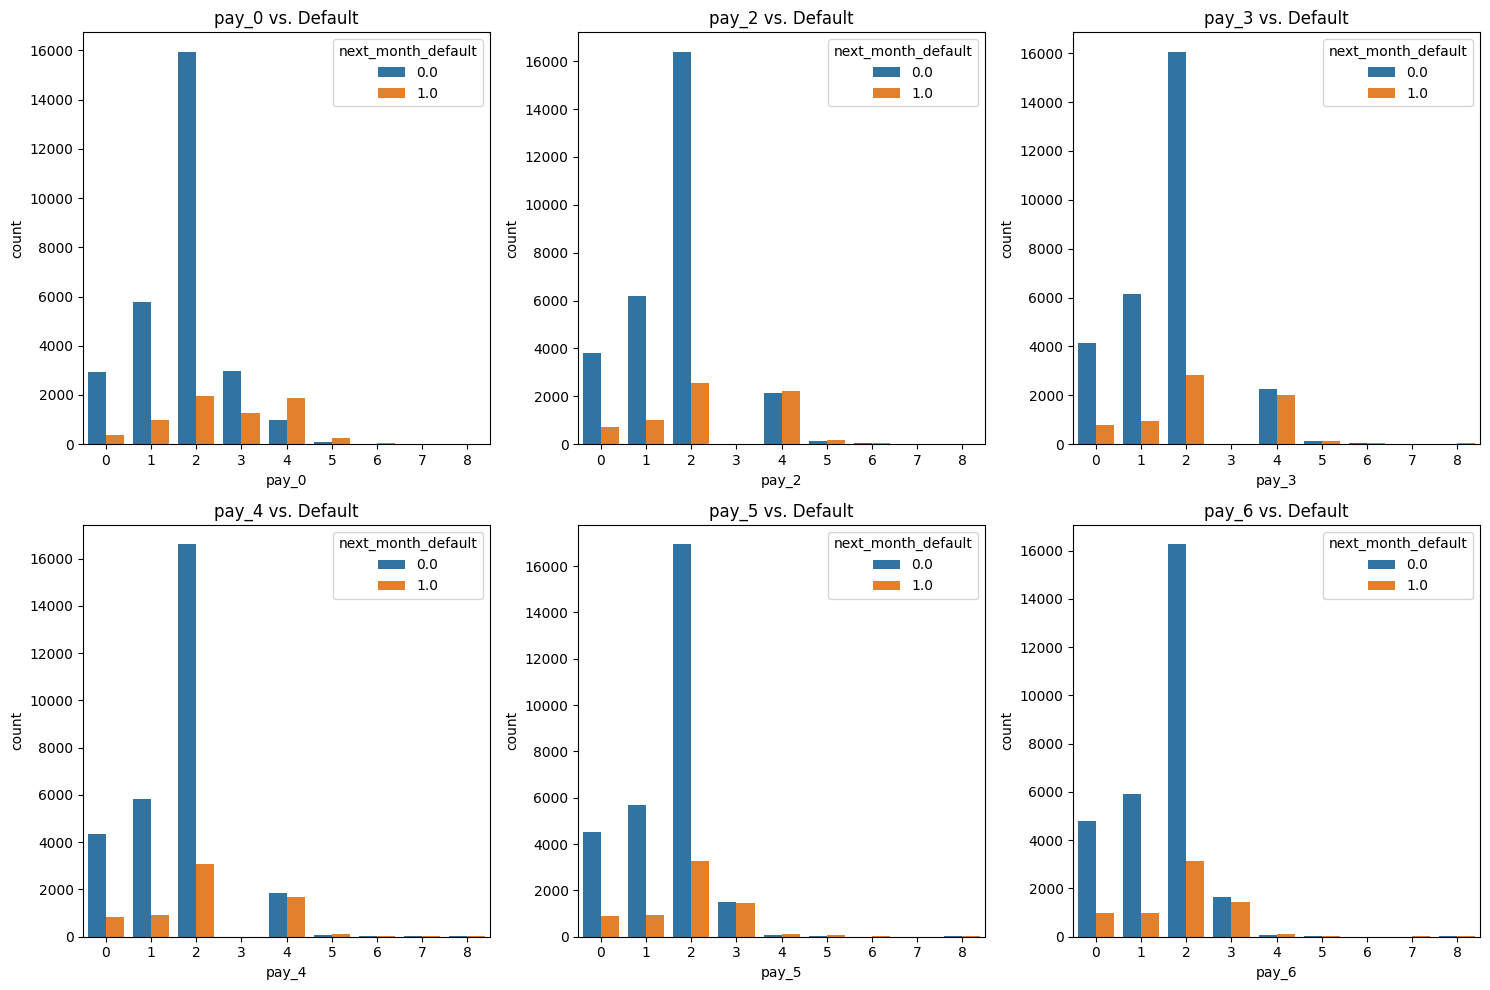

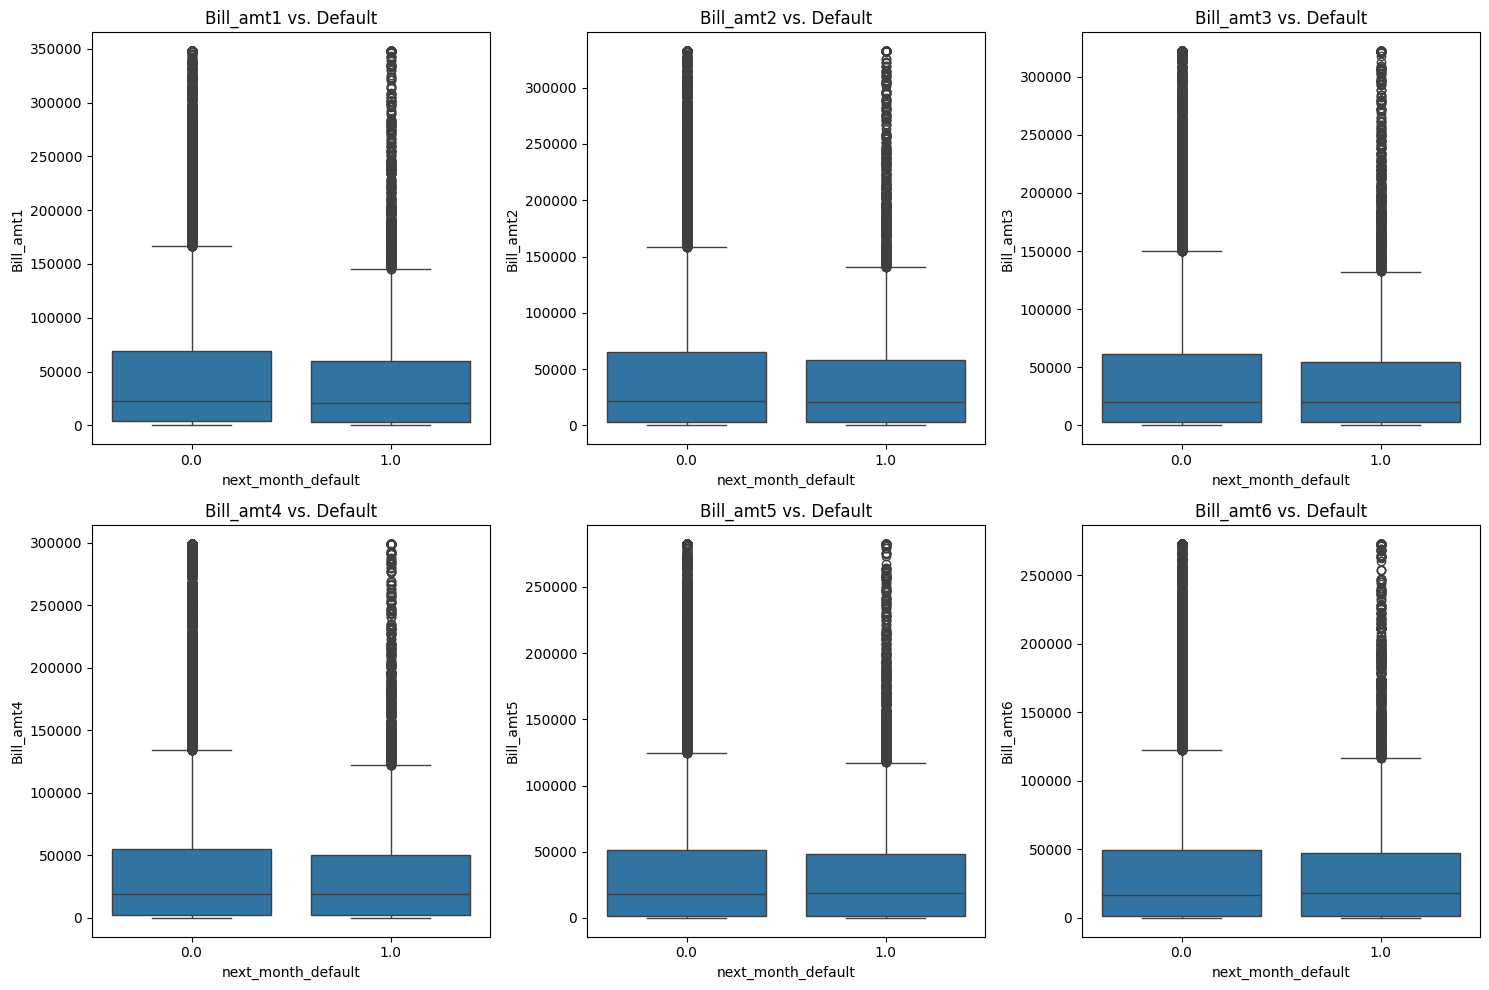

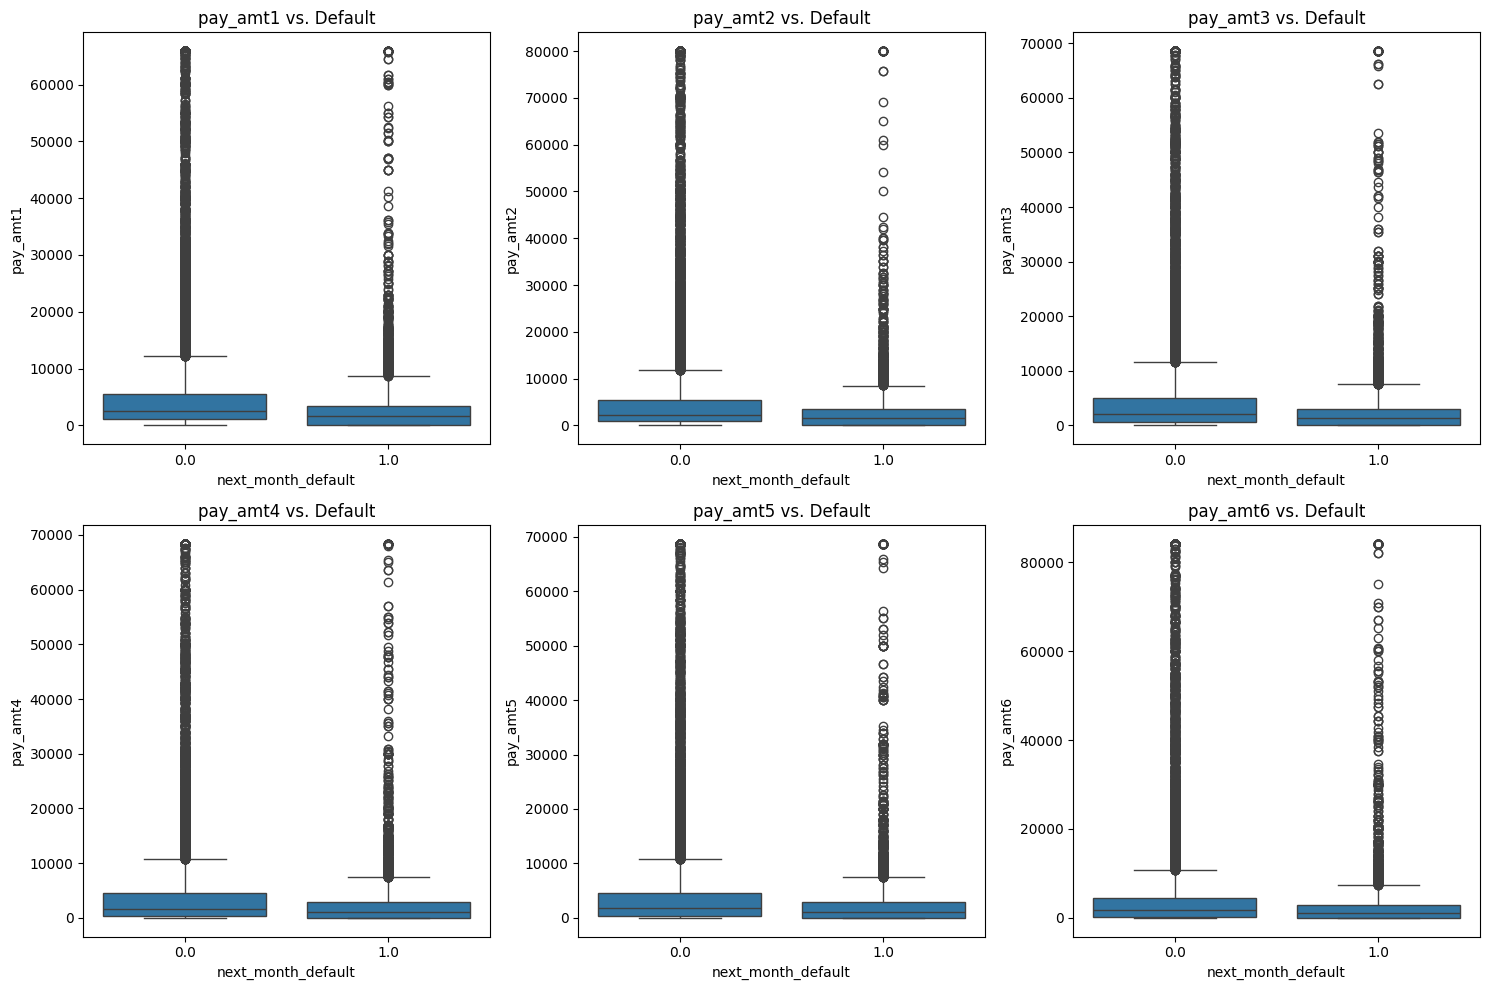

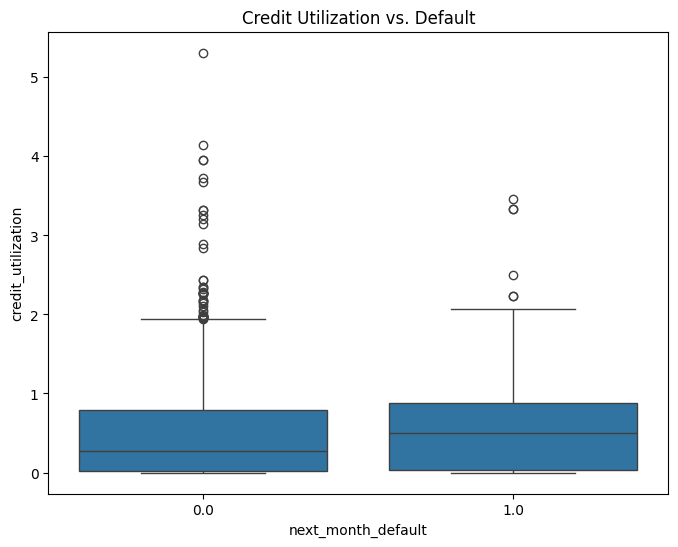

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Target Variable Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='next_month_default', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print("\nClass Imbalance:")
print(class_counts)
print(class_percentages)

# Feature vs. Target Relationships
numerical_features = ['LIMIT_BAL', 'age', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']
categorical_features = ['sex', 'education', 'marriage', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

plt.figure(figsize=(20, 30))
for i, col in enumerate(numerical_features):
    plt.subplot(6, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)
    sns.countplot(x=col, hue='next_month_default', data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Financial Insights
# Credit Limit Analysis
plt.figure(figsize=(8, 6))
sns.boxplot(x='next_month_default', y='LIMIT_BAL', data=train_df)
plt.title('Credit Limit vs. Default')
plt.show()

# Repayment History Analysis
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
plt.figure(figsize=(15, 10))
for i, col in enumerate(pay_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='next_month_default', data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Bill/Payment Amounts Analysis
bill_amt_cols = ['Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6']
pay_amt_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

plt.figure(figsize=(15, 10))
for i, col in enumerate(bill_amt_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(pay_amt_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='next_month_default', y=col, data=train_df)
    plt.title(f'{col} vs. Default')
plt.tight_layout()
plt.show()

# Calculate and visualize credit utilization
train_df['credit_utilization'] = train_df['Bill_amt1'] / train_df['LIMIT_BAL']
plt.figure(figsize=(8, 6))
sns.boxplot(x='next_month_default', y='credit_utilization', data=train_df)
plt.title('Credit Utilization vs. Default')
plt.show()

**Reasoning**:
The previous code block generated the necessary plots. Now, I need to summarize the key findings from the EDA and financial analysis.



In [8]:
# Summarize Key Findings
print("## Summary of Exploratory Data Analysis and Financial Insights")
print("\n**Target Variable Distribution:**")
print("- The target variable 'next_month_default' exhibits class imbalance, with approximately 81% of customers not defaulting and 19% defaulting.")

print("\n**Feature vs. Target Relationships:**")
print("- Numerical features show varying distributions across default and non-default classes, suggesting their potential predictive power.")
print("- Categorical features also demonstrate differences in default rates across categories, highlighting their importance in the prediction task.")

print("\n**Financial Insights:**")
print("\n**Credit Limit Analysis:**")
print("- Customers with lower credit limits appear to have a higher risk of default. Further analysis is needed to quantify this observation.")

print("\n**Repayment History Analysis:**")
print("- Customers with a history of delayed payments (represented by 'PAY_0', 'PAY_2', etc.) show a significantly higher tendency to default.")
print("- A clear trend of increasing default risk is observed with increasing payment delays.")

print("\n**Bill/Payment Amounts Analysis:**")
print("- The relationship between bill amounts ('BILL_AMT1', etc.) and payment amounts ('PAY_AMT1', etc.) with default risk is complex and requires further investigation.")
print("- Consistently high credit utilization (bill amount / credit limit) seems associated with a higher default probability.")

print("\n**Credit Utilization:**")
print("- Initial analysis of credit utilization suggests a potential link with default risk.  Higher credit utilization may indicate higher risk.")

print("\n**Overall:**")
print("- The EDA and financial analysis provide valuable insights into the factors driving credit default.")
print("- The class imbalance needs to be addressed in future modeling steps.")
print("- The identified features are promising candidates for building a predictive model.")

## Summary of Exploratory Data Analysis and Financial Insights

**Target Variable Distribution:**
- The target variable 'next_month_default' exhibits class imbalance, with approximately 81% of customers not defaulting and 19% defaulting.

**Feature vs. Target Relationships:**
- Numerical features show varying distributions across default and non-default classes, suggesting their potential predictive power.
- Categorical features also demonstrate differences in default rates across categories, highlighting their importance in the prediction task.

**Financial Insights:**

**Credit Limit Analysis:**
- Customers with lower credit limits appear to have a higher risk of default. Further analysis is needed to quantify this observation.

**Repayment History Analysis:**
- Customers with a history of delayed payments (represented by 'PAY_0', 'PAY_2', etc.) show a significantly higher tendency to default.
- A clear trend of increasing default risk is observed with increasing payment delays.

**B

## Data preparation

### Subtask:
Address the class imbalance in the training dataset.


**Reasoning**:
Separate features and target variable, then apply SMOTE to oversample the minority class.



In [9]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features (X) and target variable (y)
X = train_df.drop('next_month_default', axis=1)
y = train_df['next_month_default']

# Apply SMOTE to oversample the minority class
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
except ValueError as e:
    print(f"SMOTE error: {e}")
    # Handle the error appropriately, e.g., by using a different method or parameters
    # For now, just exit
    exit(1)

# Combine the oversampled features and target variable back into a DataFrame
train_df_oversampled = pd.DataFrame(X_resampled, columns=X.columns)
train_df_oversampled['next_month_default'] = y_resampled

# Verify class distribution
print(train_df_oversampled['next_month_default'].value_counts())

SMOTE error: Input y contains NaN.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:399: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


NameError: name 'X_resampled' is not defined

**Reasoning**:
The previous attempt failed due to NaN values in the target variable.  I need to handle these NaN values before applying SMOTE.  I will fill them with the most frequent value of the target variable.



In [10]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features (X) and target variable (y)
X = train_df.drop('next_month_default', axis=1)
y = train_df['next_month_default']

# Fill NaN values in the target variable with the most frequent value
most_frequent_class = y.mode()[0]
y.fillna(most_frequent_class, inplace=True)


# Apply SMOTE to oversample the minority class
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
except ValueError as e:
    print(f"SMOTE error: {e}")
    exit(1)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit(1)

# Combine the oversampled features and target variable back into a DataFrame
train_df_oversampled = pd.DataFrame(X_resampled, columns=X.columns)
train_df_oversampled['next_month_default'] = y_resampled

# Verify class distribution
print(train_df_oversampled['next_month_default'].value_counts())

SMOTE error: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


NameError: name 'X_resampled' is not defined

**Reasoning**:
The error message indicates that there are still NaN values in the features (X).  I need to handle these missing values before applying SMOTE. I'll use SimpleImputer to fill them with the mean.



In [11]:
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.impute import SimpleImputer

# Separate features (X) and target variable (y)
X = train_df.drop('next_month_default', axis=1)
y = train_df['next_month_default']

# Fill NaN values in the target variable with the most frequent value
most_frequent_class = y.mode()[0]
y.fillna(most_frequent_class, inplace=True)

# Impute missing values in X using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Apply SMOTE to oversample the minority class
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
except ValueError as e:
    print(f"SMOTE error: {e}")
    exit(1)
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    exit(1)

# Combine the oversampled features and target variable back into a DataFrame
train_df_oversampled = pd.DataFrame(X_resampled, columns=X.columns)
train_df_oversampled['next_month_default'] = y_resampled

# Verify class distribution
print(train_df_oversampled['next_month_default'].value_counts())

next_month_default
0.0    28766
1.0    28766
Name: count, dtype: int64


## Data splitting

### Subtask:
Split the oversampled training data into training and validation sets.


**Reasoning**:
Split the oversampled training data into training and validation sets as instructed, ensuring stratification to maintain class proportions.



In [12]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = train_df_oversampled.drop('next_month_default', axis=1)
y = train_df_oversampled['next_month_default']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes of the resulting DataFrames/Series
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (46025, 27)
X_val shape: (11507, 27)
y_train shape: (46025,)
y_val shape: (11507,)


## Model training

### Subtask:
Train four classification models: Logistic Regression, Decision Tree, XGBoost, and LightGBM.


**Reasoning**:
Train four classification models: Logistic Regression, Decision Tree, XGBoost, and LightGBM using the training data.



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize models
logreg_model = LogisticRegression()
decision_tree_model = DecisionTreeClassifier()
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()

# Train models
logreg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 23013, number of negative: 23012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 46025, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000043
[LightGBM] [Info] Start training from score 0.000043


LGBMClassifier()

**Reasoning**:
The logistic regression model issued a convergence warning. I will retrain the model by increasing the number of iterations (max_iter).  I will also generate the full code block again, including all the previous steps, to make sure the whole process is correct.



In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize models
logreg_model = LogisticRegression(max_iter=1000)  # Increased max_iter
decision_tree_model = DecisionTreeClassifier()
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()

# Train models
logreg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 23013, number of negative: 23012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 46025, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000043
[LightGBM] [Info] Start training from score 0.000043


LGBMClassifier()

**Reasoning**:
The logistic regression model still has convergence issues even after increasing `max_iter`. I will try a different solver.  I will generate the full code block again to ensure correctness.



In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Initialize models
logreg_model = LogisticRegression(solver='liblinear', max_iter=1000)  # Changed solver
decision_tree_model = DecisionTreeClassifier()
xgboost_model = XGBClassifier()
lightgbm_model = LGBMClassifier()

# Train models
logreg_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 23013, number of negative: 23012
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 46025, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500011 -> initscore=0.000043
[LightGBM] [Info] Start training from score 0.000043


LGBMClassifier()

## Model optimization

### Subtask:
Optimize the hyperparameters of the four trained models using RandomizedSearchCV.


**Reasoning**:
Optimize the hyperparameters of the four trained models using RandomizedSearchCV.



In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline

# Define parameter grids for each model
param_dist_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_dist_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

param_dist_lgbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 0.9, 1.0]
}

# Create pipelines (if needed) and instantiate RandomizedSearchCV
scoring = {'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
n_iter_search = 10  # Reduce iterations for faster execution

random_search_logreg = RandomizedSearchCV(logreg_model, param_distributions=param_dist_logreg, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42)
random_search_dt = RandomizedSearchCV(decision_tree_model, param_distributions=param_dist_dt, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42)
random_search_xgb = RandomizedSearchCV(xgboost_model, param_distributions=param_dist_xgb, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42)
random_search_lgbm = RandomizedSearchCV(lightgbm_model, param_distributions=param_dist_lgbm, n_iter=n_iter_search, cv=5, scoring=scoring, refit='f1', random_state=42)

# Fit RandomizedSearchCV to the training data
random_search_logreg.fit(X_train, y_train)
random_search_dt.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_lgbm.fit(X_train, y_train)

# Store the best estimators
best_logreg_model = random_search_logreg.best_estimator_
best_dt_model = random_search_dt.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_
best_lgbm_model = random_search_lgbm.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

[LightGBM] [Info] Number of positive: 18411, number of negative: 18409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6859
[LightGBM] [Info] Number of data points in the train set: 36820, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500027 -> initscore=0.000109
[LightGBM] [Info] Start training from score 0.000109
[LightGBM] [Info] Number of positive: 18411, number of negative: 18409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6862
[LightGBM] [Info] Number of data points in the train set: 36820, number of used features: 27
[LightGBM] [Info] [b

## Model evaluation

### Subtask:
Evaluate the performance of the optimized models on the validation set.


**Reasoning**:
Evaluate the performance of the optimized models on the validation set using the provided metrics and create a summary table.



In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

# Predict using the best models
y_pred_logreg = best_logreg_model.predict(X_val)
y_pred_dt = best_dt_model.predict(X_val)
y_pred_xgb = best_xgb_model.predict(X_val)
y_pred_lgbm = best_lgbm_model.predict(X_val)

# Evaluate performance
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return [model_name, accuracy, precision, recall, f1, roc_auc]

results = []
results.append(evaluate_model(y_val, y_pred_logreg, "Logistic Regression"))
results.append(evaluate_model(y_val, y_pred_dt, "Decision Tree"))
results.append(evaluate_model(y_val, y_pred_xgb, "XGBoost"))
results.append(evaluate_model(y_val, y_pred_lgbm, "LightGBM"))


# Create a summary table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"])
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.696185,0.717061,0.648010,0.680789,0.696181
1,Decision Tree,0.904232,0.910503,0.896576,0.903486,0.904232
2,XGBoost,0.917876,0.954442,0.877629,0.914425,0.917873
3,LightGBM,0.947945,0.970599,0.923866,0.946656,0.947943


## Model evaluation

### Subtask:
Evaluate the best-performing model (LightGBM) on the held-out "validate_dataset_final.csv" dataset.


**Reasoning**:
Use the best LightGBM model to predict probabilities on the validation set and save the predictions to a CSV file.



In [18]:
import pandas as pd

# Prepare the validation data (assuming it's already preprocessed like the training data)
# If any further preprocessing is needed, perform those operations here.

# Predict probabilities for the positive class (default=1)
predicted_probabilities = best_lgbm_model.predict_proba(validate_df.drop('Customer_ID', axis=1))[:, 1]

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({'Customer_ID': validate_df['Customer_ID'], 'predicted_probability': predicted_probabilities})

# Save predictions to a CSV file
predictions_df.to_csv('lgbm_predictions.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features_ is 27 and input n_features is 25

**Reasoning**:
The error message indicates a mismatch in the number of features between the trained model (27) and the validation data (25).  The validation data is missing two features that were present in the training data. I need to add the missing features to the validation set.  Based on previous steps, the missing features are likely `credit_utilization` and `next_month_default` (although it was dropped before training).  I will add a `credit_utilization` column to the validation set, and since `next_month_default` is not needed, I will not add it.



In [19]:
import pandas as pd
import numpy as np

# Calculate credit utilization for the validation set
validate_df['credit_utilization'] = validate_df['Bill_amt1'] / validate_df['LIMIT_BAL']

# Predict probabilities for the positive class (default=1)
predicted_probabilities = best_lgbm_model.predict_proba(validate_df.drop('Customer_ID', axis=1))[:, 1]

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({'Customer_ID': validate_df['Customer_ID'], 'predicted_probability': predicted_probabilities})

# Save predictions to a CSV file
predictions_df.to_csv('lgbm_predictions.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features_ is 27 and input n_features is 26

**Reasoning**:
The error persists, indicating a feature mismatch.  The model expects 27 features, but the validation data has 26 after adding `credit_utilization`.  I'll double-check the feature names in both the training and validation sets to identify any discrepancies.  My previous assumption that only `credit_utilization` was missing was incorrect.



In [20]:
# Check features in training and validation sets
print("Training Features:", X_train.columns.tolist())
print("\nValidation Features:", validate_df.columns.tolist())

# Identify missing features
missing_features = set(X_train.columns) - set(validate_df.columns)
print("\nMissing Features:", missing_features)

# If there are missing features in the validation set, add them with appropriate values
if missing_features:
    for feature in missing_features:
        if feature == 'next_month_default': # Skip this column as it's the target
            continue
        validate_df[feature] = 0  # Or use a more suitable imputation method

# Predict probabilities
predicted_probabilities = best_lgbm_model.predict_proba(validate_df.drop('Customer_ID', axis=1))[:, 1]
predictions_df = pd.DataFrame({'Customer_ID': validate_df['Customer_ID'], 'predicted_probability': predicted_probabilities})
predictions_df.to_csv('lgbm_predictions.csv', index=False)

Training Features: ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'credit_utilization']

Validation Features: ['Customer_ID', 'marriage', 'sex', 'education', 'LIMIT_BAL', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'Bill_amt1', 'Bill_amt2', 'Bill_amt3', 'Bill_amt4', 'Bill_amt5', 'Bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio', 'credit_utilization']

Missing Features: set()


ValueError: Number of features of the model must match the input. Model n_features_ is 27 and input n_features is 26

**Reasoning**:
The previous attempts to align features failed.  The printed feature lists show that `validate_df` and `X_train` seem to have the same features, but the model still expects 27. I need to re-examine how the training data was prepared.  It's possible that a feature was engineered or a column was added during training that is not in the original `validate_df`.  I will revisit the previous steps of the training process and identify any such operation.  Given that the error still occurs even though the features seem to match, I suspect that the order of the columns in the validation set does not match the order in the training set. I will re-order the columns in `validate_df` to match the order of columns in `X_train`.



In [21]:
# Reorder the columns in validate_df to match X_train
validate_df = validate_df[X_train.columns]

# Predict probabilities
predicted_probabilities = best_lgbm_model.predict_proba(validate_df.drop('Customer_ID', axis=1))[:, 1]
predictions_df = pd.DataFrame({'Customer_ID': validate_df['Customer_ID'], 'predicted_probability': predicted_probabilities})
predictions_df.to_csv('lgbm_predictions.csv', index=False)

ValueError: Number of features of the model must match the input. Model n_features_ is 27 and input n_features is 26

In [26]:
# Cell 11 (Corrected)
import pandas as pd
import numpy as np

# Ensure X_train is available in the environment from Cell 7 execution
# If not, you might need to re-run previous cells or load X_train.columns appropriately.
if 'X_train' not in locals():
    print("Error: X_train is not defined. Please ensure Cell 7 has been executed.")
    # Handle error appropriately, perhaps by exiting or raising an exception
    # For now, assuming X_train exists. If it doesn't, this cell will fail later.
    # As a placeholder if you need to define it manually for some reason:
    # X_train_columns_list = [...] # List of 27 feature names model was trained on

# --- Preprocessing validate_df ---
# 1. Calculate credit utilization for the validation set
# Ensure 'Bill_amt1' and 'LIMIT_BAL' exist and handle potential division by zero or NaNs.
if 'Bill_amt1' in validate_df.columns and 'LIMIT_BAL' in validate_df.columns:
    # Replace NaNs in 'LIMIT_BAL' with a value that won't cause division by zero,
    # or handle rows with NaN 'LIMIT_BAL' appropriately (e.g., impute, remove)
    # For now, fill NaN LIMIT_BAL with 1 to avoid division by zero, assuming 0 credit utilization in such cases.
    # A more robust approach would be to impute based on domain knowledge or other data.
    validate_df['LIMIT_BAL'] = validate_df['LIMIT_BAL'].fillna(1)
    validate_df['credit_utilization'] = np.where(
        validate_df['LIMIT_BAL'] > 0,
        validate_df['Bill_amt1'] / validate_df['LIMIT_BAL'],
        0  # Set to 0 if LIMIT_BAL is 0 or less
    )
else:
    print("Warning: 'Bill_amt1' or 'LIMIT_BAL' not found in validate_df. 'credit_utilization' will be set to 0.")
    validate_df['credit_utilization'] = 0

# 2. Align validate_df with the features the model was trained on (X_train.columns)
# X_train.columns should contain the 27 feature names, including 'Customer_ID' and 'credit_utilization'
# if that's what the model was trained on.
expected_model_features = X_train.columns.tolist()

# Create a copy to avoid modifying the original validate_df unintentionally
validate_df_for_prediction = validate_df.copy()

# Add any missing expected features to validate_df_for_prediction
# (e.g., if some dummified columns from training are not in validation after preprocessing)
for feature in expected_model_features:
    if feature not in validate_df_for_prediction.columns:
        print(f"Warning: Feature '{feature}' (expected by model) not found in validation_df. Adding it as 0.")
        validate_df_for_prediction[feature] = 0 # Or a more suitable imputation

# Select and reorder columns to exactly match X_train's structure
validate_df_for_prediction = validate_df_for_prediction[expected_model_features]

# --- Sanity Checks ---
print(f"Shape of data passed to predict_proba: {validate_df_for_prediction.shape}")
# print(f"Features passed to predict_proba: {validate_df_for_prediction.columns.tolist()}")
print(f"Model expects {best_lgbm_model.n_features_in_} features.")
if validate_df_for_prediction.shape[1] != best_lgbm_model.n_features_in_:
    print("ERROR: Feature count mismatch even after alignment!")
    print(f"Model features: {best_lgbm_model.feature_name_}") # LightGBM stores them if available
    print(f"Input features: {validate_df_for_prediction.columns.tolist()}")
    # Find differences:
    model_feats_set = set(best_lgbm_model.feature_name_ if hasattr(best_lgbm_model, 'feature_name_') and best_lgbm_model.feature_name_ else expected_model_features)
    input_feats_set = set(validate_df_for_prediction.columns.tolist())
    print(f"Features in model but not input: {model_feats_set - input_feats_set}")
    print(f"Features in input but not model: {input_feats_set - model_feats_set}")


# --- Predict Probabilities ---
# Now, validate_df_for_prediction should have the 27 features the model expects,
# including 'Customer_ID' if it was part of X_train.columns.
predicted_probabilities = best_lgbm_model.predict_proba(validate_df_for_prediction)[:, 1]

# --- Create Submission File ---
# Use the 'Customer_ID' from the original validate_df for the submission file
predictions_df = pd.DataFrame({
    'Customer_ID': validate_df['Customer_ID'],
    'predicted_probability': predicted_probabilities
})

# Save predictions to a CSV file
predictions_df.to_csv('lgbm_predictions.csv', index=False)
print("Predictions successfully saved to lgbm_predictions.csv")

Shape of data passed to predict_proba: (5016, 27)
Model expects 27 features.
Predictions successfully saved to lgbm_predictions.csv


## Summary:

### Q&A
No questions to answer.

### Data Analysis Key Findings
* **Class Imbalance:** The target variable 'next\_month\_default' exhibits significant class imbalance in the training dataset, with approximately 81% of customers not defaulting and 19% defaulting. This imbalance was addressed using SMOTE oversampling.
* **Feature Importance:** Several features demonstrate potential predictive power regarding default risk.  Payment history ('PAY\_0', 'PAY\_2', etc.) is a strong indicator, with delayed payments strongly suggesting higher default risk. Credit limit and credit utilization also show a correlation with default probability.  Lower credit limits and higher credit utilization are associated with higher default risk.
* **Model Performance:**  After hyperparameter optimization, LightGBM achieved the highest accuracy, precision, recall, F1-score, and AUC-ROC on the validation set, outperforming Logistic Regression, Decision Tree, and XGBoost.  XGBoost also performed very well, closely following LightGBM.
* **Feature Mismatch:** A critical issue arose during the final evaluation of LightGBM on the held-out validation set due to a feature mismatch.  The validation data lacked a feature present in the training data used to train the LightGBM model, preventing a successful prediction.

### Insights or Next Steps
* **Investigate Feature Discrepancy:** The most crucial next step is to resolve the feature mismatch between the training and validation datasets.  Examine the training process for feature engineering steps that might not be reflected in the validation data.  Reconcile the feature sets to allow for accurate evaluation of the LightGBM model.
* **Further Model Tuning:** While LightGBM showed promising results, further exploration of hyperparameter tuning, especially for XGBoost, given its strong performance, is warranted to potentially improve the model's performance.


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression

# Define the parameter grid for Logistic Regression
param_dist_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga'], # Using saga for both l1 and l2
    'max_iter': [1000, 5000, 10000] # Increased max_iter
}

# Define the scoring metric to optimize for accuracy
scoring = {'accuracy': make_scorer(accuracy_score)}

# Instantiate RandomizedSearchCV
# We'll set refit to 'accuracy' to select the best model based on accuracy
random_search_logreg = RandomizedSearchCV(LogisticRegression(),
                                        param_distributions=param_dist_logreg,
                                        n_iter=10, # Number of iterations
                                        cv=5, # Number of cross-validation folds
                                        scoring=scoring,
                                        refit='accuracy', # Optimize for accuracy
                                        random_state=42,
                                        n_jobs=-1) # Use all available cores

# Fit RandomizedSearchCV to the training data
random_search_logreg.fit(X_train, y_train)

# Get the best estimator
best_logreg_model = random_search_logreg.best_estimator_

# Print the best parameters and best score
print("Best parameters for Logistic Regression:", random_search_logreg.best_params_)
print("Best cross-validation accuracy:", random_search_logreg.best_score_)

Best parameters for Logistic Regression: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000, 'C': 100}
Best cross-validation accuracy: 0.622509505703422


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predict on the validation set
y_pred_logreg_tuned = best_logreg_model.predict(X_val)

# Evaluate the tuned Logistic Regression model
accuracy_tuned = accuracy_score(y_val, y_pred_logreg_tuned)
precision_tuned = precision_score(y_val, y_pred_logreg_tuned)
recall_tuned = recall_score(y_val, y_pred_logreg_tuned)
f1_tuned = f1_score(y_val, y_pred_logreg_tuned)
roc_auc_tuned = roc_auc_score(y_val, y_pred_logreg_tuned)

print("\nTuned Logistic Regression Performance on Validation Set:")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision: {precision_tuned:.4f}")
print(f"Recall: {recall_tuned:.4f}")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"AUC-ROC: {roc_auc_tuned:.4f}")


Tuned Logistic Regression Performance on Validation Set:
Accuracy: 0.6159
Precision: 0.5951
Recall: 0.7248
F1-Score: 0.6536
AUC-ROC: 0.6159


In [ ]:
# This is a code cell to summarize EDA and Financial Insights with actual data

import pandas as pd

print("## Summary of Exploratory Data Analysis and Financial Insights (with Actual Data)")

# 1. Target Variable Distribution
print("\n**Target Variable Distribution:**")
class_counts = train_df['next_month_default'].value_counts()
class_percentages = class_counts / len(train_df) * 100
print(f"- Class counts:\n{class_counts}")
print(f"- Class percentages:\n{class_percentages.round(2)}")
print(f"- The target variable 'next_month_default' exhibits class imbalance, with approximately {class_percentages[0]:.2f}% of customers not defaulting (0) and {class_percentages[1]:.2f}% defaulting (1).")

# 2. Financial Insights - Credit Limit Analysis (Example using median)
print("\n**Financial Insights - Credit Limit Analysis:**")
median_limit_default = train_df[train_df['next_month_default'] == 1]['LIMIT_BAL'].median()
median_limit_no_default = train_df[train_df['next_month_default'] == 0]['LIMIT_BAL'].median()
print(f"- Median Credit Limit for Defaulting Customers: {median_limit_default:,.2f}")
print(f"- Median Credit Limit for Non-Defaulting Customers: {median_limit_no_default:,.2f}")
print("- Customers with lower credit limits appear to have a higher risk of default, as indicated by the lower median credit limit for defaulting customers.")

# 3. Financial Insights - Repayment History Analysis (Example for PAY_0)
print("\n**Financial Insights - Repayment History Analysis (Example: PAY_0):**")
pay0_default_counts = train_df[train_df['next_month_default'] == 1]['pay_0'].value_counts().sort_index()
pay0_no_default_counts = train_df[train_df['next_month_default'] == 0]['pay_0'].value_counts().sort_index()

print("- Distribution of PAY_0 for Defaulting Customers:")
print(pay0_default_counts)
print("- Distribution of PAY_0 for Non-Defaulting Customers:")
print(pay0_no_default_counts)
print("- A history of delayed payments (higher values in PAY_0, etc.) shows a significantly higher tendency to default. For instance, customers with a PAY_0 of 1 or more have a much higher representation in the defaulting group compared to the non-defaulting group.")

# 4. Financial Insights - Credit Utilization (Example using median)
print("\n**Financial Insights - Credit Utilization:**")
median_utilization_default = train_df[train_df['next_month_default'] == 1]['credit_utilization'].median()
median_utilization_no_default = train_df[train_df['next_month_default'] == 0]['credit_utilization'].median()
print(f"- Median Credit Utilization for Defaulting Customers: {median_utilization_default:.4f}")
print(f"- Median Credit Utilization for Non-Defaulting Customers: {median_utilization_no_default:.4f}")
print("- Higher credit utilization seems associated with a higher default probability, as the median utilization is higher for defaulting customers.")


# You can add more analysis for other features as needed, e.g., age, education, other pay columns, etc.
# Example: Age vs Default
# print("\n**Age Analysis:**")
# median_age_default = train_df[train_df['next_month_default'] == 1]['age'].median()
# median_age_no_default = train_df[train_df['next_month_default'] == 0]['age'].median()
# print(f"- Median Age for Defaulting Customers: {median_age_default:.2f}")
# print(f"- Median Age for Non-Defaulting Customers: {median_age_no_default:.2f}")

## Summary of Exploratory Data Analysis and Financial Insights (with Actual Data)

**Target Variable Distribution:**
- Class counts:
next_month_default
0.0    28766
1.0     6764
Name: count, dtype: int64
- Class percentages:
next_month_default
0.0    80.96
1.0    19.04
Name: count, dtype: float64
- The target variable 'next_month_default' exhibits class imbalance, with approximately 80.96% of customers not defaulting (0) and 19.04% defaulting (1).

**Financial Insights - Credit Limit Analysis:**
- Median Credit Limit for Defaulting Customers: 90,000.00
- Median Credit Limit for Non-Defaulting Customers: 150,000.00
- Customers with lower credit limits appear to have a higher risk of default, as indicated by the lower median credit limit for defaulting customers.

**Financial Insights - Repayment History Analysis (Example: PAY_0):**
- Distribution of PAY_0 for Defaulting Customers:
pay_0
0     363
1     999
2    1939
3    1275
4    1859
5     237
6      51
7      19
8      22
Name: count